# Fig 4: Songs

In [1]:
import numpy as np
import pandas as pd
from scipy.fftpack import dct, idct

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from music21 import converter
matplotlib.style.use('styles.mplstyle')

import sys
sys.path.append('../')
from helpers import cm2inch, title

In [2]:
def load_contours(fn, num_samples=100):
    df = pd.read_csv(fn)
    contours = df[[str(i) for i in range(num_samples)]].values
    return contours, df

# contours, df = load_contours('../data/contours/phrase/boehme-phrase-contours.csv')

In [3]:
paths = {
    'sioux': f'../data/song-contours/densmore-teton-sioux.csv',
    'han': f'../data/song-contours/han.csv',
    'erk': '../data/song-contours/erk.csv',
}

In [4]:
contours = {}
coeffs = {}
for name, path in paths.items():
    contours[name], df = load_contours(path)
    coeffs[name] = dct(contours[name], norm='ortho')

In [5]:
def show_point(coeffs, w=None, h=None, 
               ax=None, 
               scale=.5,
               num_points=20, 
               marker=True,
               line_kws=dict(),
               marker_kws=dict()):

    if ax == None: ax = plt.gca()
        
    # Determine height/width
    yticks = np.array(ax.get_yticks())
    xticks = np.array(ax.get_xticks())
    min_x = np.min(xticks[1:] - xticks[:-1])
    min_y = np.min(yticks[1:] - yticks[:-1])
    if w is None: w = scale * min_x 
    if h is None: h = scale * min_y 
    
    # Plot a marker
    if marker:
        marker_kwargs = dict(linewidths=0.5, color='0.9', marker='+')
        marker_kwargs.update(marker_kws)
        plt.scatter(coeffs[0], coeffs[1], **marker_kwargs, )
    
    # Plot the basis function
    axins = ax.inset_axes([coeffs[0] - w/2, coeffs[1] - h/2, w, h], 
                          transform=ax.transData)
    line_kwargs = dict(color='.8', linewidth=.5)
    line_kwargs.update(line_kws)
    C = dct(np.eye(num_points), norm='ortho')[:, :len(coeffs)+1]
    axins.plot(np.dot(C, [0] + coeffs), **line_kwargs)
    
    # Heuristically set the y limits
    ylims = np.array(ax.get_ylim()) / 2
    axins.set_ylim(*ylims)
    axins.axis('off')

def show_grid(xs=None, ys=None, ax=None, **kwargs):
    if ax == None: 
        ax = plt.gca()
    if xs is None: 
        xs = ax.get_xticks()[1:-1]
    if ys is None: 
        ys = ax.get_yticks()[1:-1]
    for x in xs:
        for y in ys:
            show_point([x, y], **kwargs)

## Contours plot

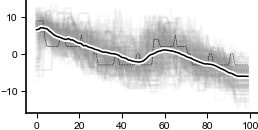

In [6]:
def show_contours(contours, alpha=.05, lw=1, ls='-', max_contours=250,
                  normalize=True, show_legend=False, mean_kws=dict(c='k'), **kwargs):
    if normalize:
        contours = contours - contours.mean(axis=1)[:, np.newaxis]
        
    kwargs = dict(alpha=alpha, lw=lw, ls=ls, **kwargs)
    xs = np.arange(contours.shape[1])
    indices = np.random.choice(np.arange(len(contours)), 
                               size=min(len(contours), max_contours))
    plt.plot(xs, contours[indices, :].T, **kwargs);
    plt.plot(xs, contours[0, :].T, '--', c='k', lw=.25, label='single contour');
    plt.plot(xs, contours.mean(axis=0).T, 'w-', lw=2.5);
    plt.plot(xs, contours.mean(axis=0).T, '-', lw=.75, label='mean', **mean_kws);
    if show_legend: plt.legend(ncol=2)
    
plt.figure(figsize=(2, 1))
show_contours(contours['sioux'], c='0.6')

## Combined plot

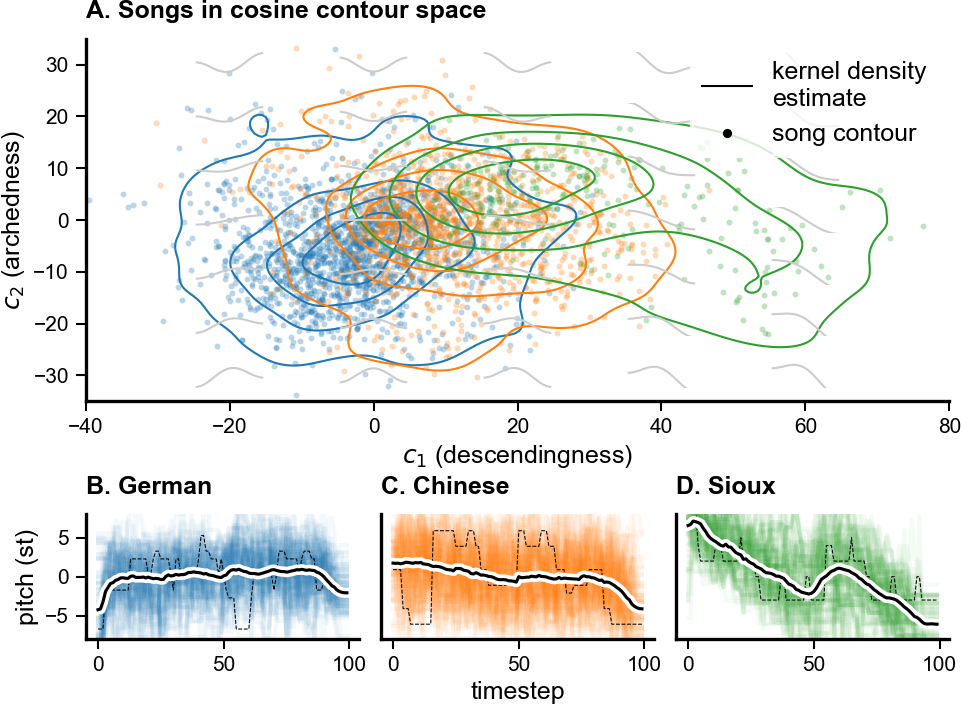

In [7]:
names = ['erk', 'han', 'sioux']

fig = plt.figure(figsize=cm2inch(8.2, 6))
gs = gridspec.GridSpec(3, 3)

fig.add_subplot(gs[:2, :])
for name in names:
    x, y = coeffs[name][:, 1:3].T
    sns.kdeplot(x=x, y=y, levels=5, linewidths=.5, alpha=1)
    plt.scatter(x, y, alpha=.3, s=2, 
                linewidths=0, edgecolors='w')
plt.xlim(-40, 80)
plt.ylim(-35, 35)
plt.xlabel('$c_1$ (descendingness)')
plt.ylabel('$c_2$ (archedness)')

plt.plot(-100, -100, 'k-', label='kernel density\nestimate', lw=.5)
plt.plot(-100, -100, 'k.', label='song contour')
plt.legend()
show_grid(marker=False)   
title('A. Songs in cosine contour space')

ax= fig.add_subplot(gs[2, 0])
show_contours(contours['erk'], c='C0', max_contours=100)
# plt.yticks([])
title('B. German')
plt.ylabel('pitch (st)')
plt.ylim(-8,8)

fig.add_subplot(gs[2, 1])
show_contours(contours['han'], c='C1', max_contours=100)
plt.yticks([])
title('C. Chinese')
plt.xlabel('timestep')
plt.ylim(-8,8)

fig.add_subplot(gs[2, 2])
show_contours(contours['sioux'], c='C2', max_contours=100)
plt.yticks([])
title('D. Sioux')
plt.ylim(-8,8)

plt.tight_layout(pad=0.05)
plt.savefig('../figures/fig04/fig04-songs.pdf')